# Multi-Class Classification on "Hardware" Category

## 1. Imports

In [1]:
import ast
import random
from collections import Counter
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from wordcloud import WordCloud

from preprocess_functions import build_tree, extract_keys, preprocess_texts, map_targets
from utils import CalibratedLabelRankClassifier, ChainOfClassifiers, LabelPowersetClassifier, \
    assess_models, prune_and_subsample, ConditionalDependencyNetwork, MetaBinaryRelevance


## 2. Configurations & Constants

### Global Configuration Constants

In [2]:
OVERWRITE = True
RETRAIN = True
RANDOM_STATE = 42
MODEL_LEVEL = 'hardware'

### Set Random Seeds

In [3]:
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

### Testing Parameters

In [4]:
TEST_SIZE = 2e-1

### Category Mappings

In [5]:
FIX_TARGETS = {
    'computer': 'computer',
    'computer components': 'computer components',
    'computer networking': 'computer networking'
}

### Base Models

In [6]:
BASE_CLASSIFIERS = {
    'logistic_regression': LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight='balanced'),
    'gaussian_nb': GaussianNB(),
    'decision_tree': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'random_forest': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'xgb': xgb.XGBClassifier(random_state=RANDOM_STATE),
}

### Directory Paths

In [7]:
COLAB_DIR = Path('/content/drive/MyDrive')
KAGGLE_DIR = Path('/kaggle/input')
LOCAL_DIR = Path('./')

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import kaggle_secrets

    IN_KAGGLE = True
except ImportError:
    IN_KAGGLE = False

if IN_COLAB:
    DATA_DIR = COLAB_DIR / 'data'
    MODELS_DIR = COLAB_DIR / 'models'
elif IN_KAGGLE:
    DATA_DIR = KAGGLE_DIR
    MODELS_DIR = KAGGLE_DIR
else:
    DATA_DIR = LOCAL_DIR / 'data'
    MODELS_DIR = LOCAL_DIR / 'models'

### Dataset & Model Paths

In [8]:
BINARY_PROBLEMS_DIR = MODELS_DIR / 'binary_problems'
ENSEMBLES_DIR = MODELS_DIR / 'ensembles'
MULTICLASS_PROBLEMS_DIR = MODELS_DIR / 'multiclass_problems'
GLOVE_DIR = MODELS_DIR / 'glove-embeddings'
GLOVE_6B_300D_TXT = GLOVE_DIR / 'glove.6B.300d.txt'

DATASET_DIR = DATA_DIR / 'tweets-dataset-for-cyberattack-detection'
THREAT_TWEETS_CSV = DATASET_DIR / 'tweets_train.csv'

BR_PKL = BINARY_PROBLEMS_DIR / f'br_{MODEL_LEVEL}.pkl'
CLR_PKL = BINARY_PROBLEMS_DIR / f'clr_{MODEL_LEVEL}.pkl'
CC_PKL = BINARY_PROBLEMS_DIR / f'cc_{MODEL_LEVEL}.pkl'

LP_PKL = MULTICLASS_PROBLEMS_DIR / f'lp_{MODEL_LEVEL}.pkl'
PST_PKL = MULTICLASS_PROBLEMS_DIR / f'pst_{MODEL_LEVEL}.pkl'

CDN_PKL = ENSEMBLES_DIR / f'pkl_{MODEL_LEVEL}.pkl'
MBR_PKL = ENSEMBLES_DIR / f'mbr_{MODEL_LEVEL}.pkl'

### Loading Models

In [9]:
br = joblib.load(filename=BR_PKL) if BR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
clr = joblib.load(filename=CLR_PKL) if CLR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cc = joblib.load(filename=CC_PKL) if CC_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
lp = joblib.load(filename=LP_PKL) if LP_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
pst = joblib.load(filename=PST_PKL) if PST_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cdn = joblib.load(filename=CDN_PKL) if CDN_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
mbr = joblib.load(filename=MBR_PKL) if MBR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)

## 3. Data Loading & Preprocessing

Load the dataset, inspect its structure, and preprocess it for machine learning models.
For the goal of the project, the categories of interest for the category 'computer security' are:
1. computer
2. computer components
3. computer networking

In [10]:
threat_tweets = (
    pd.read_csv(filepath_or_buffer=THREAT_TWEETS_CSV)
    .assign(
        tweet=lambda df: df['tweet'].apply(func=ast.literal_eval),
        watson=lambda df: df['watson'].apply(func=ast.literal_eval)
        .apply(func=lambda x: x.get('categories', []))
        .apply(func=build_tree),
        watson_list=lambda df: df['watson'].apply(func=extract_keys),
        target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_TARGETS,))
    )
    .query(expr='relevant == True')
    .drop(labels=[
        'relevant', '_id', 'date',
        'id', 'tweet', 'type',
        'annotation', 'urls', 'destination_url',
        'valid_certificate'
    ], axis=1)
    .dropna(subset=['text'], ignore_index=True)
)

threat_tweets = threat_tweets[
    threat_tweets["watson_list"].apply(lambda x: ' '.join(MODEL_LEVEL.split(sep='_')) in x)
].reset_index(drop=True)

print(f"Threat Tweets: {len(threat_tweets)}")
threat_tweets.head()

Threat Tweets: 1741


,text,watson,watson_list,target
0,Brute-force flag via #SQLi\n#security #hacking...,{'technology and computing': {'software': {'da...,"[technology and computing, software, databases...",[computer]
1,Another patched Apache Struts vulnerability ex...,{'technology and computing': {'programming lan...,"[technology and computing, programming languag...",[computer]
2,EOEO Virus Removal – Restore Infected Computer...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[computer]
3,I'm gonna go curl up in a ball and cry I guess...,{'art and entertainment': {'movies and tv': {'...,"[art and entertainment, movies and tv, movies,...",[computer]
4,@ASUS @TrendMicro The latest version of your R...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[computer networking]


## 4. Exploratory Data Analysis (EDA)
Here are uncovered patterns, relationships, and potential issues in the data that could impact model performances.

### 4.1. Text Analysis
The `text` attribute is examined using word frequency analysis, word clouds, and text length distribution.
It helps in identifying common words, potential stopwords, and variations in text length that may impact feature engineering.

#### 4.1.1. Word Frequency

In [11]:
all_words = ' '.join(threat_tweets['text']).split()
word_freq = Counter(all_words)
print("Top 10 Most Frequent Words:", word_freq.most_common(10))

Top 10 Most Frequent Words: [('Vulnerability', 367), ('to', 365), ('the', 344), ('in', 315), ('a', 303), ('Android', 263), ('Of', 262), ('of', 258), ('In', 258), ('and', 242)]


#### 4.1.2. Word Cloud

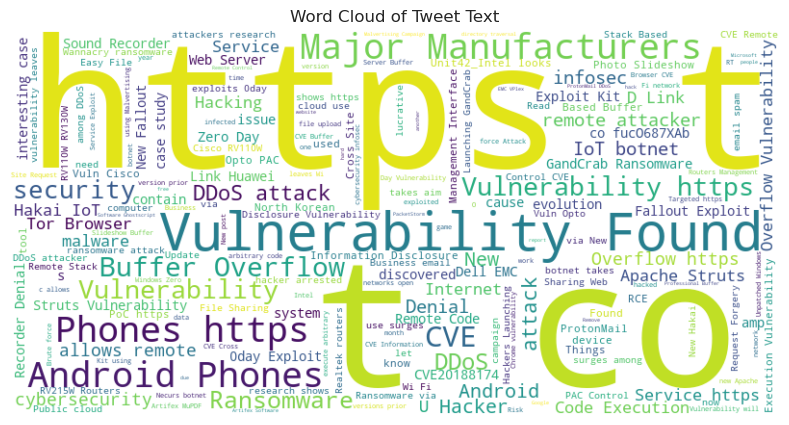

In [12]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text=' '.join(threat_tweets['text']))

plt.figure(figsize=(15, 5))
plt.imshow(X=wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()

#### 4.1.3. Text Length Distribution

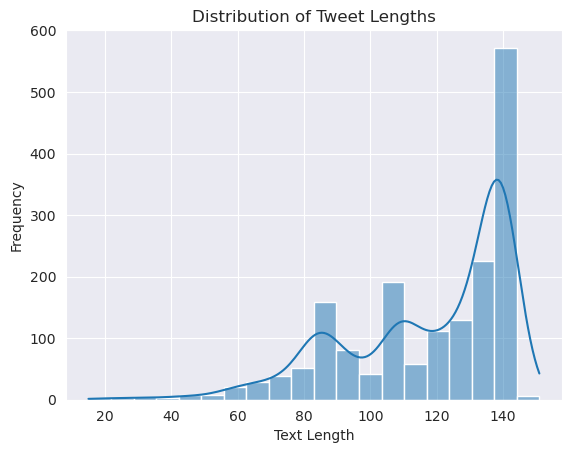

In [13]:
threat_tweets['text_length'] = threat_tweets['text'].apply(func=len)
sns.histplot(
    data=threat_tweets['text_length'],
    bins=20,
    kde=True
)
plt.title(label='Distribution of Tweet Lengths')
plt.xlabel(xlabel='Text Length')
plt.ylabel(ylabel='Frequency')
plt.show()

### 4.3. Watson List Analysis
In the `watson_list` attribute, it is performed category depth, co-occurrence patterns, and top-level category distribution analyses.

In [14]:
# Flatten watson_list and count category frequencies
all_categories = [category for sublist in threat_tweets['watson_list'] for category in sublist]
category_freq = Counter(all_categories)
print("Top 10 Most Frequent Categories:", category_freq.most_common(n=10))

Top 10 Most Frequent Categories: [('technology and computing', 1741), ('hardware', 1741), ('computer', 1375), ('computer security', 736), ('software', 637), ('antivirus and malware', 603), ('consumer electronics', 326), ('telephones', 280), ('mobile phones', 279), ('smart phones', 268)]


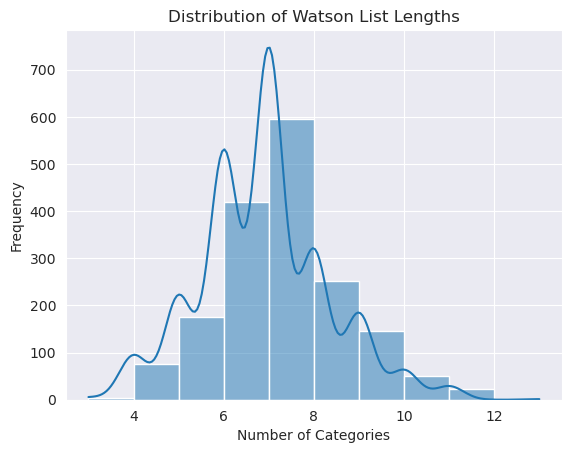

In [15]:
# Category Depth Analysis
threat_tweets['watson_list_length'] = threat_tweets['watson_list'].apply(func=len)

sns.histplot(
    data=threat_tweets['watson_list_length'],
    bins=10,
    kde=True
)

plt.title(label='Distribution of Watson List Lengths')
plt.xlabel(xlabel='Number of Categories')
plt.ylabel(ylabel='Frequency')
plt.show()

In [16]:
# Create co-occurrence matrix
co_occurrence = Counter()
for categories in threat_tweets['watson_list']:
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            co_occurrence[(categories[i], categories[j])] += 1

print("Top 10 Co-occurring Category Pairs:", co_occurrence.most_common(n=10))

Top 10 Co-occurring Category Pairs: [(('technology and computing', 'hardware'), 1741), (('technology and computing', 'computer'), 1375), (('hardware', 'computer'), 1375), (('technology and computing', 'computer security'), 736), (('technology and computing', 'software'), 637), (('technology and computing', 'antivirus and malware'), 603), (('computer security', 'antivirus and malware'), 603), (('computer security', 'hardware'), 584), (('computer security', 'computer'), 521), (('antivirus and malware', 'hardware'), 516)]


In [17]:
# Top-Level Category Distribution
top_level_categories = [category.split()[0] for category in all_categories]
top_level_freq = Counter(top_level_categories)
print("Top-Level Category Frequencies:", top_level_freq.most_common())

Top-Level Category Frequencies: [('computer', 2618), ('technology', 1741), ('hardware', 1741), ('software', 637), ('antivirus', 603), ('consumer', 327), ('telephones', 280), ('mobile', 279), ('smart', 268), ('router', 210), ('network', 166), ('operating', 142), ('databases', 136), ('networking', 113), ('business', 113), ('vpn', 109), ('programming', 102), ('portable', 87), ('disks', 76), ('law,', 70), ('linux', 69), ('society', 64), ('servers', 60), ('home', 57), ('javascript', 54), ('health', 53), ('art', 53), ('science', 50), ('printers,', 47), ('laptop', 46), ('crime', 42), ('personal', 38), ('government', 37), ('java', 37), ('motherboards', 36), ('internet', 34), ('graphics', 28), ('finance', 28), ('company', 27), ('sports', 26), ('mp3', 26), ('scanners', 26), ('memory', 25), ('disease', 24), ('weather', 24), ('merger', 22), ('meteorological', 22), ('unix', 21), ('email', 20), ('plumbing', 20), ('addiction', 20), ('alcoholism', 20), ('hobbies', 19), ('windows', 19), ('printers', 19

### 4.4. Target Analysis

Target Frequencies:
computer: 1292
computer networking: 219
computer components: 169
other: 61


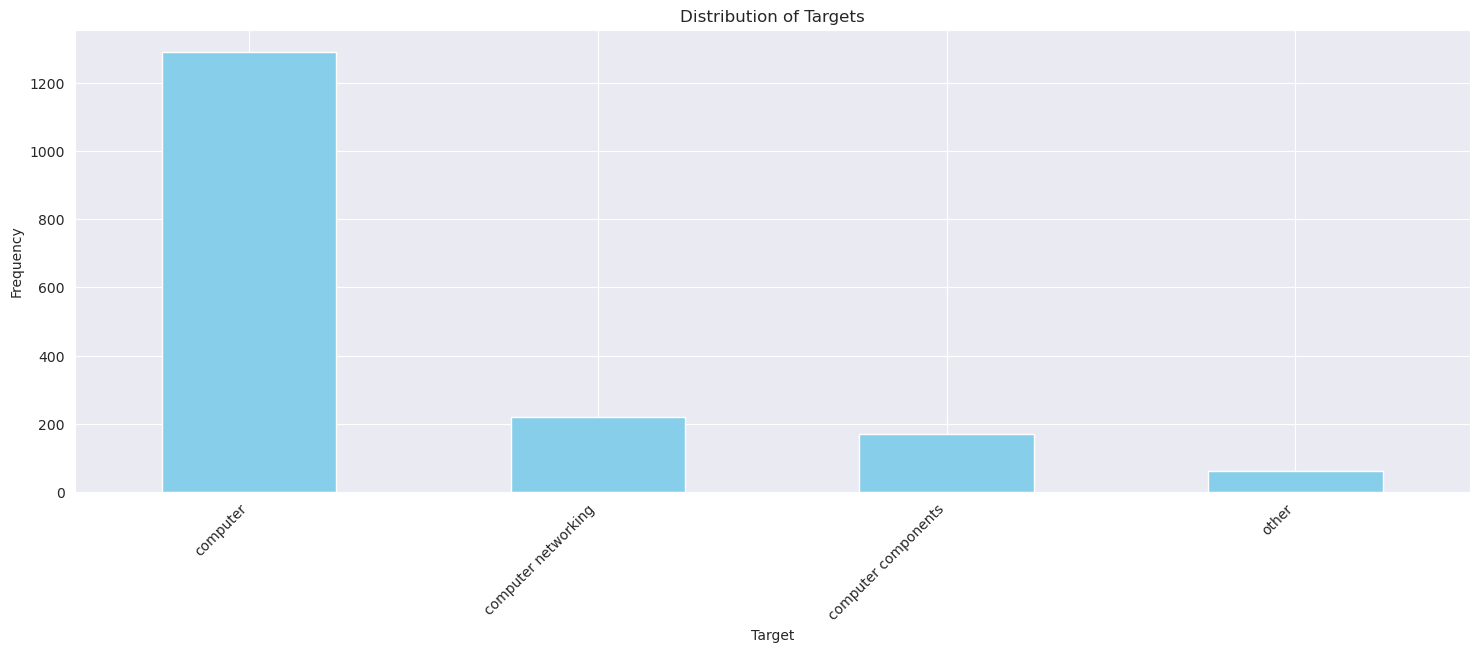

In [18]:
class_freq = Counter([item[0] for item in threat_tweets['target']])

print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Target Frequencies:
('computer',): 1292
('computer networking',): 164
('computer components',): 140
('other',): 61
('computer networking', 'computer'): 55
('computer components', 'computer'): 28
('computer components', 'computer networking'): 1


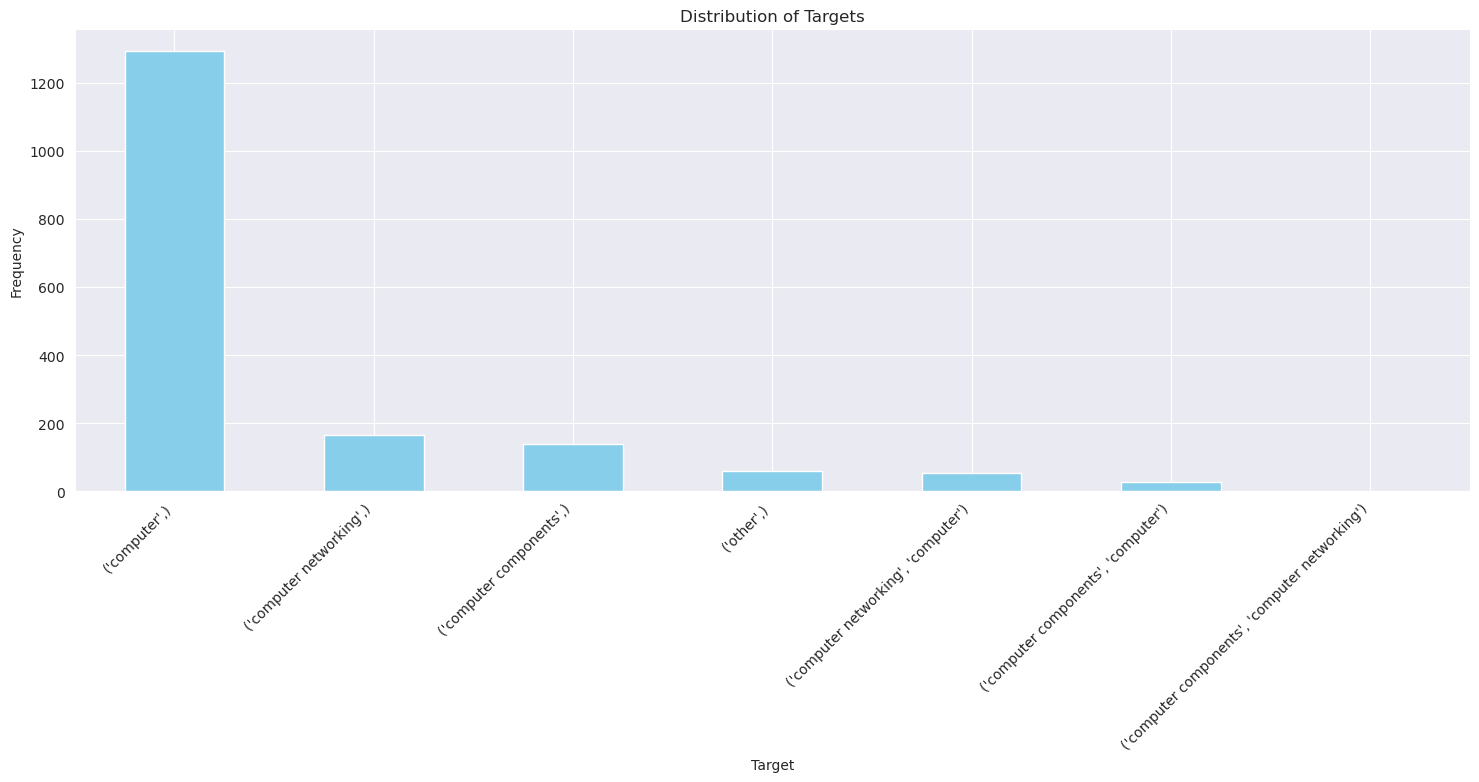

In [19]:
target_freq = Counter(tuple(item) for item in threat_tweets['target'])

print("Target Frequencies:")
for target, freq in target_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))

(pd.Series(data={str(k): v for k, v in target_freq.items()})
 .sort_values(ascending=False)
 .plot(kind='bar', color='skyblue'))

plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [20]:
# Multi-Label Analysis
multi_label_counts = threat_tweets['target'].apply(func=lambda x: len(x) > 1).sum()
print(f"Number of tweets with multiple targets: {multi_label_counts}")

Number of tweets with multiple targets: 84


In [21]:
# Text-Target Relationship
target_text_pairs = [
    (target, text)
    for targets, text in zip(threat_tweets['target'], threat_tweets['text'])
    for target in targets
]

target_text_df = pd.DataFrame(data=target_text_pairs, columns=['target', 'text'])

for target in class_freq:
    target_texts = target_text_df[target_text_df['target'].apply(func=lambda x: target in x)]['text']
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(raw_documents=target_texts)
    word_freq = pd.Series(data=word_counts.sum(axis=0).A1, index=vectorizer.get_feature_names_out())
    print(f"Top 10 words for target '{target}':")
    print(word_freq.nlargest(10))

Top 10 words for target 'computer':
https            2003
vulnerability     668
android           281
cve               264
2018              257
ransomware        231
ddos              222
phones            216
major             215
manufacturers     211
dtype: int64
Top 10 words for target 'computer networking':
https            248
vulnerability    102
cve               59
routers           48
tor               45
botnet            40
2018              39
huawei            39
link              36
iot               34
dtype: int64
Top 10 words for target 'computer components':
https            161
vulnerability     28
denial            26
ransomware        26
service           26
2018              25
attacks           25
cve               25
evolution         23
case              22
dtype: int64
Top 10 words for target 'other':
https            76
vulnerability    21
scanner          13
2018              8
little            8
cve               7
70                6
angriffe          

## 5. Feature Engineering

In [22]:
# Find valid targets (with frequency ≥ 5)
valid_targets = {target for target, freq in target_freq.items() if freq >= 5}

# Filter the DataFrame to keep only valid targets
filtered_df = threat_tweets[threat_tweets['target'].apply(lambda x: tuple(x) in valid_targets)]

# Reset the index (optional)
filtered_df = filtered_df.reset_index(drop=True)

# Print the updated target frequencies
updated_target_freq = Counter(tuple(item) for item in filtered_df['target'])
print("Updated Target Frequencies:")
for target, freq in updated_target_freq.most_common():
    print(f"{target}: {freq}")

Updated Target Frequencies:
('computer',): 1292
('computer networking',): 164
('computer components',): 140
('other',): 61
('computer networking', 'computer'): 55
('computer components', 'computer'): 28


Preprocess the `text` column into embeddings

In [23]:
X = preprocess_texts(
    list_str=filtered_df['text'],
    model_path=GLOVE_6B_300D_TXT,
    embedding_dim=300
)

Convert the `target` column into a binary multi-label matrix

In [24]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y=filtered_df['target'])

Perform pruning and subsampling of the dataset to remove infrequent targets

In [25]:
X_pst, y_pst, label_map_pst, _ = prune_and_subsample(
    x=X,
    y=y,
    pruning_threshold=np.median(np.array(list(target_freq.values()))) * .25,
    max_sub_samples=round(np.median(np.array(list(target_freq.values()))) * .25)
)

Create a dictionary that maps label indices to unique label sets

In [26]:
unique_label_sets, y_lp = np.unique(ar=y, axis=0, return_inverse=True)
label_map_lp = {i: tuple(lbl_set) for i, lbl_set in enumerate(unique_label_sets)}

In [27]:
smote = SMOTE(random_state=42)
X, y_lp = smote.fit_resample(X, y_lp)
y = np.array(unique_label_sets[y_lp])
print(f"{X.shape}, {len(y_lp)}")

(7752, 300), 7752


## 6. Model Training

In [28]:
# BR, CLR, CC, CDN, MBR, LP
X_train, X_val, y_train, y_val, y_train_lp, y_val_lp = train_test_split(
    X, y, y_lp,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_lp
)

print(f"{'Training:':<15}\tX = {str(X_train.shape[0]) + ' × ' + str(X_train.shape[1]):<15}\ty = {str(y_train.shape[0]) + ' × ' + str(y_train.shape[1]):<15}")
print(f"{'Validation:':<15}\tX = {str(X_val.shape[0]) + ' × ' + str(X_val.shape[1]):<15}\ty = {str(y_val.shape[0]) + ' × ' + str(y_val.shape[1]):<15}")

Training:      	X = 6201 × 300     	y = 6201 × 4       
Validation:    	X = 1551 × 300     	y = 1551 × 4       


In [29]:
# PSt
X_train_pst, X_val_pst, y_train_pst, y_val_pst = train_test_split(
    X_pst, y_pst,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_pst
)
print(
    f"{'Training:':<15}\tX = {str(X_train_pst.shape[0]) + ' × ' + str(X_train_pst.shape[1]):<15}\ty = {str(len(y_train_pst)):<15}")
print(
    f"{'Validation:':<15}\tX = {str(X_val_pst.shape[0]) + ' × ' + str(X_val_pst.shape[1]):<15}\ty = {str((len(y_val_pst))):<15}")

Training:      	X = 1392 × 300     	y = 1392           
Validation:    	X = 348 × 300      	y = 348            


### 4.1. Binary Problems


#### 4.1.1. BR (Binary Relevance)


In [30]:
if RETRAIN:
    for k in tqdm(BASE_CLASSIFIERS.keys()):
        br[k] = OneVsRestClassifier(estimator=BASE_CLASSIFIERS[k]).fit(X=X_train, y=y_train)

100%|██████████| 5/5 [01:00<00:00, 12.16s/it]


#### 4.1.2. CLR (Calibrated Label Ranking)


In [31]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = CalibratedLabelRankClassifier(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        clr[k] = model.fit(
            x=X_train,
            y=[list(mlb.classes_[np.where(row == 1)[0]]) for row in y_train]
        )

100%|██████████| 5/5 [01:55<00:00, 23.02s/it]


#### 4.1.3. CC (Classifier Chains)


In [32]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ChainOfClassifiers(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        cc[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 5/5 [01:08<00:00, 13.63s/it]


### 4.2. Multi-class Problems



#### 4.2.1. LP (Label Powerset)


In [33]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_lp,
            random_state=RANDOM_STATE
        )

        lp[k] = model.fit(
            x=X_train,
            y=y_train_lp
        )

100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


#### 4.2.2. PSt (Pruned Sets)


In [34]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_pst,
            random_state=RANDOM_STATE
        )

        pst[k] = model.fit(
            x=X_train_pst,
            y=y_train_pst
        )

100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


### 4.3. Ensembles


#### 4.3.1. CDN (Conditional Dependency Network)


In [35]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ConditionalDependencyNetwork(
            classifier=v,
            num_iterations=100,
            burn_in=10
        )

        cdn[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 5/5 [00:48<00:00,  9.78s/it]


#### 4.3.2. MBR (Meta-Binary Relevance)


In [36]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = MetaBinaryRelevance(
            classifier=v,
            use_cross_val=True,
            n_splits=5
        )

        mbr[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 5/5 [05:41<00:00, 68.25s/it]


## 7. Model Evaluation

In [37]:
performances = {}

### 7.1. Binary Problems



#### 7.1.1. BR (Binary Relevance)


In [38]:
performances['BR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=br,
    classes=mlb.classes_
)

In [39]:
y_val_hat = performances['BR']['Model'].predict(X_val)
print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                     precision    recall  f1-score   support

           computer       0.99      0.97      0.98       776
computer components       0.99      0.99      0.99       517
computer networking       0.99      0.99      0.99       517
              other       1.00      1.00      1.00       258

          micro avg       0.99      0.98      0.99      2068
          macro avg       0.99      0.99      0.99      2068
       weighted avg       0.99      0.98      0.99      2068
        samples avg       0.98      0.98      0.98      2068

Accuracy:	0.9736
AUC:	0.9915


#### 7.1.2. CLR (Calibrated Label Ranking)


In [40]:
performances['CLR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=clr,
    classes=mlb.classes_
)

In [41]:
y_val_hat = performances['CLR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                     precision    recall  f1-score   support

           computer       0.99      0.97      0.98       776
computer components       0.99      0.99      0.99       517
computer networking       0.99      1.00      0.99       517
              other       0.99      1.00      0.99       258

          micro avg       0.99      0.99      0.99      2068
          macro avg       0.99      0.99      0.99      2068
       weighted avg       0.99      0.99      0.99      2068
        samples avg       0.98      0.98      0.98      2068

Accuracy:	0.9761
AUC:	0.9923


#### 7.1.3. CC (Classifier Chains)


In [42]:
performances['CC'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cc,
    classes=mlb.classes_
)

In [43]:
y_val_hat = performances['CC']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                     precision    recall  f1-score   support

           computer       0.99      0.98      0.99       776
computer components       0.98      0.99      0.99       517
computer networking       0.99      1.00      0.99       517
              other       0.98      1.00      0.99       258

          micro avg       0.99      0.99      0.99      2068
          macro avg       0.99      0.99      0.99      2068
       weighted avg       0.99      0.99      0.99      2068
        samples avg       0.99      0.99      0.99      2068

Accuracy:	0.9845
AUC:	0.9934


### 7.2. Multi-class Problems




#### 7.2.1. LP (Label Powerset)



In [44]:
performances['LP'] = assess_models(
    x=X_val,
    y=np.array([list(label_map_lp[yp]) for yp in y_val_lp]),
    technique=lp,
    classes=mlb.classes_
)

In [45]:
y_val_hat = performances['LP']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                     precision    recall  f1-score   support

           computer       0.99      0.98      0.99       776
computer components       0.99      0.99      0.99       517
computer networking       0.99      0.99      0.99       517
              other       0.99      1.00      0.99       258

          micro avg       0.99      0.99      0.99      2068
          macro avg       0.99      0.99      0.99      2068
       weighted avg       0.99      0.99      0.99      2068
        samples avg       0.99      0.99      0.99      2068

Accuracy:	0.9871
AUC:	0.9942


#### 7.2.2. PSt (Pruned Sets)


In [46]:
performances['PST'] = assess_models(
    x=X_val_pst,
    y=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    technique=pst,
    classes=mlb.classes_
)

In [47]:
y_val_hat = performances['PST']['Model'].predict(X_val_pst)

print(classification_report(
    y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(
    f"Accuracy:\t{accuracy_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_pred=y_val_hat):.4f}")
try:
    print(
        f"AUC:\t{roc_auc_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_score=y_val_hat):.4f}")
except ValueError:
    print(f"AUC:\tNot defined")

                     precision    recall  f1-score   support

           computer       0.95      0.91      0.93       275
computer components       0.69      0.74      0.71        34
computer networking       0.70      0.75      0.73        44
              other       0.64      0.75      0.69        12

          micro avg       0.88      0.87      0.87       365
          macro avg       0.75      0.79      0.76       365
       weighted avg       0.88      0.87      0.87       365
        samples avg       0.88      0.87      0.87       365

Accuracy:	0.8534
AUC:	0.8566


### 7.3. Ensembles


#### 7.3.1. CDN (Conditional Dependency Network)


In [48]:
performances['CDN'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cdn,
    classes=mlb.classes_
)

In [49]:
y_val_hat = performances['CDN']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                     precision    recall  f1-score   support

           computer       0.98      0.94      0.96       776
computer components       0.98      1.00      0.99       517
computer networking       0.95      0.99      0.97       517
              other       0.97      1.00      0.98       258

          micro avg       0.97      0.97      0.97      2068
          macro avg       0.97      0.98      0.97      2068
       weighted avg       0.97      0.97      0.97      2068
        samples avg       0.96      0.97      0.96      2068

Accuracy:	0.9471
AUC:	0.9825


#### 7.3.2. MBR (Meta-Binary Relevance)


In [50]:
performances['MBR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=mbr,
    classes=mlb.classes_
)

In [51]:
y_val_hat = performances['MBR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                     precision    recall  f1-score   support

           computer       0.99      0.98      0.99       776
computer components       0.99      0.99      0.99       517
computer networking       0.99      1.00      1.00       517
              other       1.00      1.00      1.00       258

          micro avg       0.99      0.99      0.99      2068
          macro avg       0.99      0.99      0.99      2068
       weighted avg       0.99      0.99      0.99      2068
        samples avg       0.99      0.99      0.99      2068

Accuracy:	0.9845
AUC:	0.9952


## 8. Summary


In [52]:
performances = pd.DataFrame(performances).T
performances

,Accuracy,Classifier,Model,Precision example-based,Recall example-based,F1 example-based,Hamming loss,Micro precision,Micro recall,Micro F1,Macro precision,Macro recall,Macro F1,Coverage,Classification
BR,0.973565,xgb,OneVsRestClassifier(estimator=XGBClassifier(ba...,0.976467,0.978401,0.977004,0.007737,0.993164,0.983559,0.988338,0.994151,0.986786,0.990435,1.402966,precision recall f1-s...
CLR,0.976144,xgb,CalibratedLabelRankClassifier(classes=array(['...,0.978723,0.981302,0.979583,0.007415,0.991732,0.985977,0.988846,0.991452,0.988881,0.990133,1.394584,precision recall f1-s...
CC,0.984526,xgb,"ChainOfClassifiers(classes=array(['computer', ...",0.985816,0.987105,0.986245,0.007092,0.988417,0.990329,0.989372,0.986765,0.99275,0.989709,1.374597,precision recall f1-s...
LP,0.987105,xgb,LabelPowersetClassifier(classifier=XGBClassifi...,0.988395,0.988717,0.988395,0.005964,0.990817,0.991296,0.991056,0.990057,0.993233,0.991625,1.368794,precision recall f1-s...
PST,0.853448,logistic_regression,LabelPowersetClassifier(classifier=LogisticReg...,0.877874,0.872126,0.872605,0.06681,0.877778,0.865753,0.871724,0.746549,0.785187,0.76438,1.448276,precision recall f1-s...
CDN,0.94842,logistic_regression,ConditionalDependencyNetwork(classifier=Logist...,0.962605,0.967118,0.963035,0.017247,0.975279,0.972921,0.974098,0.974539,0.980345,0.977217,1.450677,precision recall f1-s...
MBR,0.984526,xgb,MetaBinaryRelevance(classifier=XGBClassifier(b...,0.987427,0.989362,0.987965,0.004674,0.994183,0.991779,0.99298,0.994998,0.993716,0.99435,1.370084,precision recall f1-s...


In [53]:
if OVERWRITE:
    joblib.dump(br, BR_PKL, compress=9)
    joblib.dump(clr, CLR_PKL, compress=9)
    joblib.dump(cc, CC_PKL, compress=9)
    joblib.dump(lp, LP_PKL, compress=9)
    joblib.dump(pst, PST_PKL, compress=9)
    joblib.dump(cdn, CDN_PKL, compress=9)
    joblib.dump(mbr, MBR_PKL, compress=9)